<a href="https://colab.research.google.com/github/bayjan/idep_demo/blob/master/idepDemo_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing some parts of the results using code instead of GUI
Here we will try to reproduce PCA results obtained using iDEP tool with the demo data.

Some code have been directly copied from **R** tab (the last tab) in the tool's web-site at: **http://bioinformatics.sdstate.edu/idep/**

and also its GitHub repo here at:**https://github.com/iDEP-SDSU/idep/tree/master/shinyapps/idep** 

In [0]:
# In our case expression_file is an input file
expression_file = "https://raw.githubusercontent.com/iDEP-SDSU/idep/master/shinyapps/idep/exampleData/BcellGSE71176_p53.csv"
sampleInfoFile="https://raw.githubusercontent.com/iDEP-SDSU/idep/master/shinyapps/idep/exampleData/BcellGSE71176_p53_sampleInfo.csv"

In [0]:
readData <- function(inFile ) {

				# these packages moved here to reduce loading time
				library(edgeR,verbose=FALSE) # count data D.E.
				library(DESeq2,verbose=FALSE) # count data analysis

				dataTypeWarning =0
				dataType =c(TRUE)

				#---------------Read file
				x <- read.csv(inFile)	# try CSV
				if(dim(x)[2] <= 2 )   # if less than 3 columns, try tab-deliminated
					x <- read.table(inFile, sep="\t",header=TRUE)	
				#-------Remove non-numeric columns, except the first column
				
				for(i in 2:dim(x)[2])
					dataType = c( dataType, is.numeric(x[,i]) )
				if(sum(dataType) <=2) return (NULL)  # only less than 2 columns are numbers
				x <- x[,dataType]  # only keep numeric columns
				
				# rows with all missing values
				ix = which( apply(x[,-1],1, function(y) sum( is.na(y) ) ) != dim(x)[2]-1 )
				x <- x[ix,]
				
				dataSizeOriginal = dim(x); dataSizeOriginal[2] = dataSizeOriginal[2] -1
				
				x[,1] <- toupper(x[,1])
				x[,1] <- gsub(" ","",x[,1]) # remove spaces in gene ids
				x = x[order(- apply(x[,2:dim(x)[2]],1,sd) ),]  # sort by SD
				x <- x[!duplicated(x[,1]) ,]  # remove duplicated genes
				rownames(x) <- x[,1]
				x <- as.matrix(x[,c(-1)])
				
				# remove "-" or "." from sample names
				colnames(x) = gsub("-","",colnames(x))
				colnames(x) = gsub("\\.","",colnames(x))

				
				#cat("\nhere",dim(x))
				# missng value for median value
				if(sum(is.na(x))>0) {# if there is missing values
					if(input_missingValue =="geneMedian") { 
						rowMedians <- apply(x,1, function (y)  median(y,na.rm=T))
						for( i in 1:dim(x)[2] ) {
							ix = which(is.na(x[,i]) )
							x[ix,i] <- rowMedians[ix]						
						}
							
					} else if(input_missingValue =="treatAsZero") {
						x[is.na(x) ] <- 0					
					} else if (input_missingValue =="geneMedianInGroup") {
						sampleGroups = detectGroups( colnames(x))
						for (group in unique( sampleGroups) ){		
							samples = which( sampleGroups == group )
							rowMedians <- apply(x[,samples, drop=F],1, function (y)  median(y,na.rm=T))
							for( i in  samples ) { 
								ix = which(is.na(x[ ,i] ) )	
								if(length(ix) >0 )
									x[ix, i  ]  <- rowMedians[ix]
							}										
						}
						
						# missing for entire sample group, use median for all samples
						if(sum(is.na(x) )>0 ) { 
							rowMedians <- apply(x,1, function (y)  median(y,na.rm=T))
							for( i in 1:dim(x)[2] ) {
								ix = which(is.na(x[,i]) )
								x[ix,i] <- rowMedians[ix]						
							}						
						}
					}
				}

				# Compute kurtosis
				mean.kurtosis = mean(apply(x,2, kurtosis),na.rm=T)
				rawCounts = NULL
				pvals= NULL
				if (input_dataFileFormat == 2 ) {  # if FPKM, microarray

					if ( is.integer(x) ) dataTypeWarning = 1;  # Data appears to be read counts

					#-------------filtering
					#tem <- apply(x,1,max)
					#x <- x[which(tem > input_lowFilter),]  # max by row is at least 
					x <- x[ which( apply( x, 1,  function(y) sum(y >= input_lowFilter)) >= input_NminSamples2 ) , ] 

					
					x <- x[which(apply(x,1, function(y) max(y)- min(y) ) > 0  ),]  # remove rows with all the same levels

					#--------------Log transform
					# Takes log if log is selected OR kurtosis is big than 100
					if ( (input_transform == TRUE) | (mean.kurtosis > kurtosis.log ) ) 
						x = log(x+abs( input_logStart),2)

					tem <- apply(x,1,sd) 
					x <- x[order(-tem),]  # sort by SD

				} else 
					if( input_dataFileFormat == 1) {  # counts data


					# data not seems to be read counts
					if(!is.integer(x) & mean.kurtosis < kurtosis.log ) {
						dataTypeWarning = -1
					}
					# not used as some counts data like those from CRISPR screen
					#validate(   # if Kurtosis is less than a threshold, it is not read-count
					#	need(mean.kurtosis > kurtosis.log, "Data does not seem to be read count based on distribution. Please double check.")
					# )
					x <- round(x,0) # enforce the read counts to be integers. Sailfish outputs has decimal points.
					#x <- x[ which( apply(x,1,max) >= input_minCounts ) , ] # remove all zero counts
					

					# remove genes if it does not at least have minCounts in at least NminSamples
					#x <- x[ which( apply(x,1,function(y) sum(y>=input_minCounts)) >= input_NminSamples ) , ]  # filtering on raw counts
					# using counts per million (CPM) for filtering out genes.
                                             # CPM matrix                  #N samples > minCounts
					x <- x[ which( apply( cpm(DGEList(counts = x)), 1,  
							function(y) sum(y>=input_minCounts)) >= input_NminSamples ) , ] 
					


					rawCounts = x; # ??? 
					# construct DESeqExpression Object
					# colData = cbind(colnames(x), as.character(detectGroups( colnames(x) )) )
					tem = rep("A",dim(x)[2]); tem[1] <- "B"   # making a fake design matrix to allow process, even when there is no replicates
					colData = cbind(colnames(x), tem )
					colnames(colData)  = c("sample", "groups")
					dds <- DESeqDataSetFromMatrix(countData = x, colData = colData, design = ~ groups)
					dds <- estimateSizeFactors(dds) # estimate size factor for use in normalization later for started log method


					# regularized log  or VST transformation
					if( input_CountsTransform == 3 ) { # rlog is slow, only do it with 10 samples
						if(dim(x)[2]<=20 ) { 
						 x <- rlog(dds, blind=TRUE); x <- assay(x) } else 
						 x <- log2( counts(dds, normalized=TRUE) + input_countsLogStart ) 
						 }  

						else {
						if ( input_CountsTransform == 2 ) {    # vst is fast but aggressive
							x <- vst(dds, blind=TRUE)
							x <- assay(x)  
						} else{  # normalized by library sizes and add a constant.
							x <- log2( counts(dds, normalized=TRUE) + input_countsLogStart )   # log(x+c) 
							# This is equivalent to below. But the prior counts is more important
							#x <- cpm(DGEList(counts = x),log=TRUE, prior.count=input_countsLogStart )  #log CPM from edgeR
							#x <- x-min(x)  # shift values to avoid negative numbers
						}
					}
				} else 
					if( input_dataFileFormat == 3)	{  # other data type

						#neg_lfc neg_fdr pos_lfc pos_fdr 
						#11       1      11       1 
						
						n2 = ( dim(x)[2] %/% 2) # 5 --> 2
						# It looks like it contains P values
						# ranges of columns add 0.2 and round to whole. For P value columns this should be 1
						tem = round( apply(x, 2, function( y) max(y)- min(y))  + .2)     
						if( sum(tem[(1:n2)*2  ] ==  1 ) == n2 | 
							sum(tem[(1:n2)*2-1  ] ==  1 ) == n2 ) { 		
							x = x[,1:(2*n2) ,drop=FALSE ] # if 5, change it to 4			
							if(tem[2] == 1) { # FDR follows Fold-change
								pvals = x [,2*(1:n2 ),drop=FALSE ]  # 2, 4, 6
								x = x[, 2*(1:n2 )-1,drop=FALSE]   # 1, 3, 5

							} else {	# FDR follows Fold-change
								pvals = x [,2*(1:n2 )-1,drop=FALSE ]  # 2, 4, 6		
								x = x[, 2*(1: n2 ),drop=FALSE]   # 1, 3, 5
							}
						}
					ix =  which(apply(x,1, function(y) max(y)- min(y) ) > 0  )
					x <- x[ix,]  # remove rows with all the same levels
					if(!is.null(pvals) )
						pvals = pvals[ix,]
						
					}
					
					
				dataSize = dim(x);
				if(!(dim(x)[1]>5 & dim(x)[2]>1)) 
				stop ( "Data file not recognized. Please double check.")


				
				sampleInfoDemo=NULL
				if( input_goButton >0)
					sampleInfoDemo <- t( read.csv(demoDataFile2,row.names=1,header=T,colClasses="character") )

					finalResult <- list(data = as.matrix(x), mean.kurtosis = mean.kurtosis, rawCounts = rawCounts, dataTypeWarning=dataTypeWarning, dataSize=c(dataSizeOriginal,dataSize),sampleInfoDemo=sampleInfoDemo, pvals =pvals )
				return(finalResult)

	}

In [4]:
new.bio.packages <- c("edgeR", "DESeq2")
if(length(new.bio.packages)){
    if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
    BiocManager::install(new.bio.packages, suppressUpdates = T)
}	

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.3 (2020-02-29)

Installing package(s) 'BiocVersion', 'edgeR', 'DESeq2'

also installing the dependencies ‘bit’, ‘bitops’, ‘formatR’, ‘bit64’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘matrixStats’, ‘lambda.r’, ‘futile.options’, ‘RSQLite’, ‘XML’, ‘xtable’, ‘png’, ‘jpeg’, ‘checkmate’, ‘GenomeInfoDb’, ‘XVector’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘AnnotationDbi’, ‘annotate’, ‘Formula’, ‘latticeExtra’, ‘acepack’, ‘gridExtra’, ‘data.table’, ‘htmlTable’, ‘viridis’, ‘limma’, ‘locfit’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘genefilter’, ‘geneplotter’, ‘Hmisc’, ‘RcppArmadillo’


Old packages: 'curl', 'dplyr', 'farver', 'ggplot2', 'haven', 'later',
  'lubridate', 'processx', 'rex', 'rmarkdown', 'rprojroot', 'systemfonts',
  'vctrs', 'nlme'



In [7]:
readData.out <- readData(expression_file)

Loading required package: limma

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

ERROR: ignored

In [8]:
install.packages("e1071")
library("e1071")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [9]:
readData.out <- readData(expression_file)

ERROR: ignored

In [10]:
input_dataFileFormat <- 1
kurtosis.log = 50  # log transform is enforced when kurtosis is big
# Parameters
input_missingValue <- 'geneMedian'	#Missing values imputation method
input_dataFileFormat <- 1	#1- read counts, 2 FKPM/RPKM or DNA microarray
input_minCounts <- 0.5	#Min counts
input_NminSamples <- 1	#Minimum number of samples 
input_countsLogStart <- 4	#Pseudo count for log CPM
input_CountsTransform <- 1	#Methods for data transformation of counts. 1-EdgeR's logCPM; 2-VST; 3-rlog 
input_goButton=0
readData.out <- readData(expression_file)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [85]:
head(readData.out$data)

,p53_mock_1,p53_mock_2,p53_mock_3,p53_mock_4,p53_IR_1,p53_IR_2,p53_IR_3,p53_IR_4,null_mock_1,null_mock_2,null_IR_1,null_IR_2
ENSMUSG00000075014,5.986190,10.245204,11.622005,12.445437,19.58986,21.07925,8.279954,17.40506,13.23741,12.91427,6.949322,14.57512
ENSMUSG00000076617,18.174331,18.020764,17.901045,16.892389,18.06544,18.52019,16.933927,17.68636,17.18909,17.39665,17.663021,17.21374
ENSMUSG00000015656,15.349228,15.086274,15.392536,14.817324,15.95674,15.75896,16.233039,16.04712,15.03582,14.98886,18.603855,17.00075
ENSMUSG00000052305,13.766147,11.436670,10.523028,15.927563,10.57175,11.22625,10.125088,10.20851,11.81668,17.59129,10.311098,15.82093
ENSMUSG00000069917,13.511114,11.202619,10.240337,15.915347,10.33765,11.20676,10.280270,10.32910,11.51218,17.41403,10.236792,15.73450
ENSMUSG00000075015,4.023733,7.791965,9.161421,9.809036,16.98655,18.47457,5.767006,14.96939,10.59269,10.25800,4.742948,12.00540


In [86]:
dim(readData.out$data)

[1] 6882   12

In [0]:
readSampleInfo <- function(inFile){

				dataTypeWarning =0
				dataType =c(TRUE)

				#---------------Read file
				x <- read.csv(inFile,row.names=1,header=T,colClasses="character")	# try CSV
				if(dim(x)[2] <= 2 )   # if less than 3 columns, try tab-deliminated
					x <- read.table(inFile, row.names=1,sep="\t",header=TRUE,colClasses="character")
				# remove "-" or "." from sample names
				colnames(x) = gsub("-","",colnames(x))
				colnames(x) = gsub("\\.","",colnames(x))	

				#----------------Matching with column names of expression file
				#ix = match(toupper(colnames(readData.out$data)), toupper(colnames(x)) ) 
				ix = match(toupper(colnames(readData.out$data)), toupper(gsub("wt","p53",colnames(x))))
				ix = ix[which(!is.na(ix))] # remove NA

				if(! ( length(unique(ix) ) == dim(readData.out$data)[2] 
							& dim(x)[1]>=1 & dim(x)[1] <500 ) ) # at least one row, it can not be more than 500 rows
					stop( "Error!!! Sample information file not recognized. Sample names must be exactly the same. Each row is a factor. Each column represent a sample.  Please see documentation on format.")
				
				
				#-----------Double check factor levels, change if needed
				# remove "-" or "." from factor levels
				for( i in 1:dim(x)[1]) {
					x[i,] = gsub("-","",x[i,])
					x[i,] = gsub("\\.","",x[i,])				
				}
				# if levels from different factors match
				if( length(unique(ix) ) == dim(readData.out$data)[2]) { # matches exactly
					x = x[,ix]
					# if the levels of different factors are the same, it may cause problems
					if( sum( apply(x, 1, function(y) length(unique(y)))) > length(unique(unlist(x) ) ) ) {
						tem2 =apply(x,2, function(y) paste0( names(y),y)) # factor names are added to levels
						rownames(tem2) = rownames(x)
						x <- tem2				
					}
					return(t( x ) )			
				} else retrun(NULL)
							
				
}

In [0]:
readSampleInfo.out <- readSampleInfo(sampleInfoFile) 

In [87]:
head(readSampleInfo.out)

,p53,Treatment
wt_mock_1,wt,mock
wt_mock_2,wt,mock
wt_mock_3,wt,mock
wt_mock_4,wt,mock
wt_IR_1,wt,IR
wt_IR_2,wt,IR


In [88]:
dim(readSampleInfo.out)

[1] 12  2

In [0]:
convertedData <- function() {
		if( is.null(converted.out ) ) return( readData.out$data) # if id or species is not recognized use original data.
			
				if(input_noIDConversion) return( readData.out$data )
				
				mapping <- converted.out$conversionTable
				# cat (paste( "\nData:",input_selectOrg) )
				x =readData.out$data

				rownames(x) = toupper(rownames(x))
				# any gene not recognized by the database is disregarded
				# x1 = merge(mapping[,1:2],x,  by.y = 'row.names', by.x = 'User_input')
				# the 3 lines keeps the unrecogized genes using original IDs
				x1 = merge(mapping[,1:2],x,  by.y = 'row.names', by.x = 'User_input', all.y=TRUE)

				# original IDs used if ID is not matched in database
				ix = which(is.na(x1[,2]) )
				x1[ix,2] = x1[ix,1] 
				
				#multiple matched IDs, use the one with highest SD
				tem = apply(x1[,3:(dim(x1)[2])],1,sd)
				x1 = x1[order(x1[,2],-tem),]
				x1 = x1[!duplicated(x1[,2]) ,]
				rownames(x1) = x1[,2]
				x1 = as.matrix(x1[,c(-1,-2)])
				tem = apply(x1,1,sd)
				x1 = x1[order(-tem),]  # sort again by SD
				return(x1)

	}

In [17]:
convertedData.out <- convertedData()

ERROR: ignored

In [0]:
converted.out = NULL
convertedData.out <- convertedData()

In [89]:
head(convertedData.out)

,p53_mock_1,p53_mock_2,p53_mock_3,p53_mock_4,p53_IR_1,p53_IR_2,p53_IR_3,p53_IR_4,null_mock_1,null_mock_2,null_IR_1,null_IR_2
ENSMUSG00000075014,5.986190,10.245204,11.622005,12.445437,19.58986,21.07925,8.279954,17.40506,13.23741,12.91427,6.949322,14.57512
ENSMUSG00000076617,18.174331,18.020764,17.901045,16.892389,18.06544,18.52019,16.933927,17.68636,17.18909,17.39665,17.663021,17.21374
ENSMUSG00000015656,15.349228,15.086274,15.392536,14.817324,15.95674,15.75896,16.233039,16.04712,15.03582,14.98886,18.603855,17.00075
ENSMUSG00000052305,13.766147,11.436670,10.523028,15.927563,10.57175,11.22625,10.125088,10.20851,11.81668,17.59129,10.311098,15.82093
ENSMUSG00000069917,13.511114,11.202619,10.240337,15.915347,10.33765,11.20676,10.280270,10.32910,11.51218,17.41403,10.236792,15.73450
ENSMUSG00000075015,4.023733,7.791965,9.161421,9.809036,16.98655,18.47457,5.767006,14.96939,10.59269,10.25800,4.742948,12.00540


In [90]:
dim(convertedData.out)

[1] 6882   12

In [0]:
# Define sample groups based on column names
 detectGroups <- function (x){  # x are col names
	tem <- gsub("[0-9]*$","",x) # Remove all numbers from end
	#tem = gsub("_Rep|_rep|_REP","",tem)
	tem <- gsub("_$","",tem); # remove "_" from end
	tem <- gsub("_Rep$","",tem); # remove "_Rep" from end
	tem <- gsub("_rep$","",tem); # remove "_rep" from end
	tem <- gsub("_REP$","",tem)  # remove "_REP" from end
 	return( tem )
 }

In [0]:
# Define sample groups based on column names
 detectGroups_1xx <- function (x){  # x are col names
	tem <- gsub("_.+$","",x) # Remove all numbers from end
  tem <- gsub("p53","wt",tem)
 	return( tem )
 }

In [0]:
################################################################
# PCA
################################################################

PCAplot <- function() {   #PCA
	 x <- convertedData.out;
	 pca.object <- prcomp(t(x))
		
	pcaData = as.data.frame(pca.object$x[,1:2]); pcaData = cbind(pcaData,detectGroups_1xx(colnames(x)) )
	colnames(pcaData) = c("PC1", "PC2", "Sample_Name")
	percentVar=round(100*summary(pca.object)$importance[2,1:2],0)
	if(is.null(readSampleInfo.out)) { 
		p=ggplot(pcaData, aes(PC1, PC2, color=Sample_Name, shape = Sample_Name)) + geom_point(size=5) 
		} else {
		pcaData = cbind(pcaData,readSampleInfo.out )
		p=ggplot(pcaData, aes_string("PC1", "PC2", color=input_selectFactors,shape=input_selectFactors2)) + geom_point(size=5) 
		
		}
	p=p+xlab(paste0("PC1: ",percentVar[1],"% variance")) 
	p=p+ylab(paste0("PC2: ",percentVar[2],"% variance")) 
	p=p+ggtitle("Principal component analysis (PCA)")+coord_fixed(ratio=1.0)+ 
     theme(plot.title = element_text(size = 16,hjust = 0.5)) + theme(aspect.ratio=1) +
	 theme(axis.text.x = element_text( size = 16),
	       axis.text.y = element_text( size = 16),
		   axis.title.x = element_text( size = 16),
		   axis.title.y = element_text( size = 16) ) +
	theme(legend.text=element_text(size=16))
	   print(p)
}

In [22]:
input_selectFactors <- 'Sample_Name'	#Factor coded by color
input_selectFactors2 <- 'Sample_Name'	#Factor coded by shape
PCAplot()

ERROR: ignored

In [0]:
library(ggplot2)

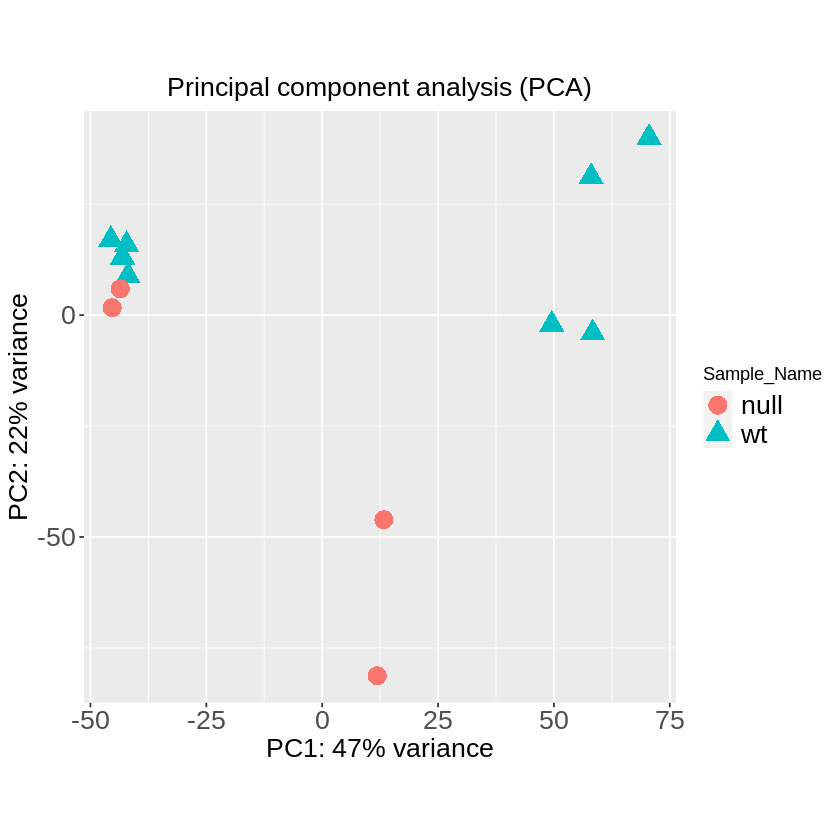

In [24]:
input_selectFactors <- 'Sample_Name'	#Factor coded by color
input_selectFactors2 <- 'Sample_Name'	#Factor coded by shape
PCAplot()

### Now we have finished reproducing the exactly the same plot, we need to start adapting it

Let's try the followings
*   Increase the figure size
*   Plot principal components **1** and **3** instead of **1** and **2**

In [0]:
library(repr)
options(repr.plot.width=10, repr.plot.height=10)

* Increase the figure size

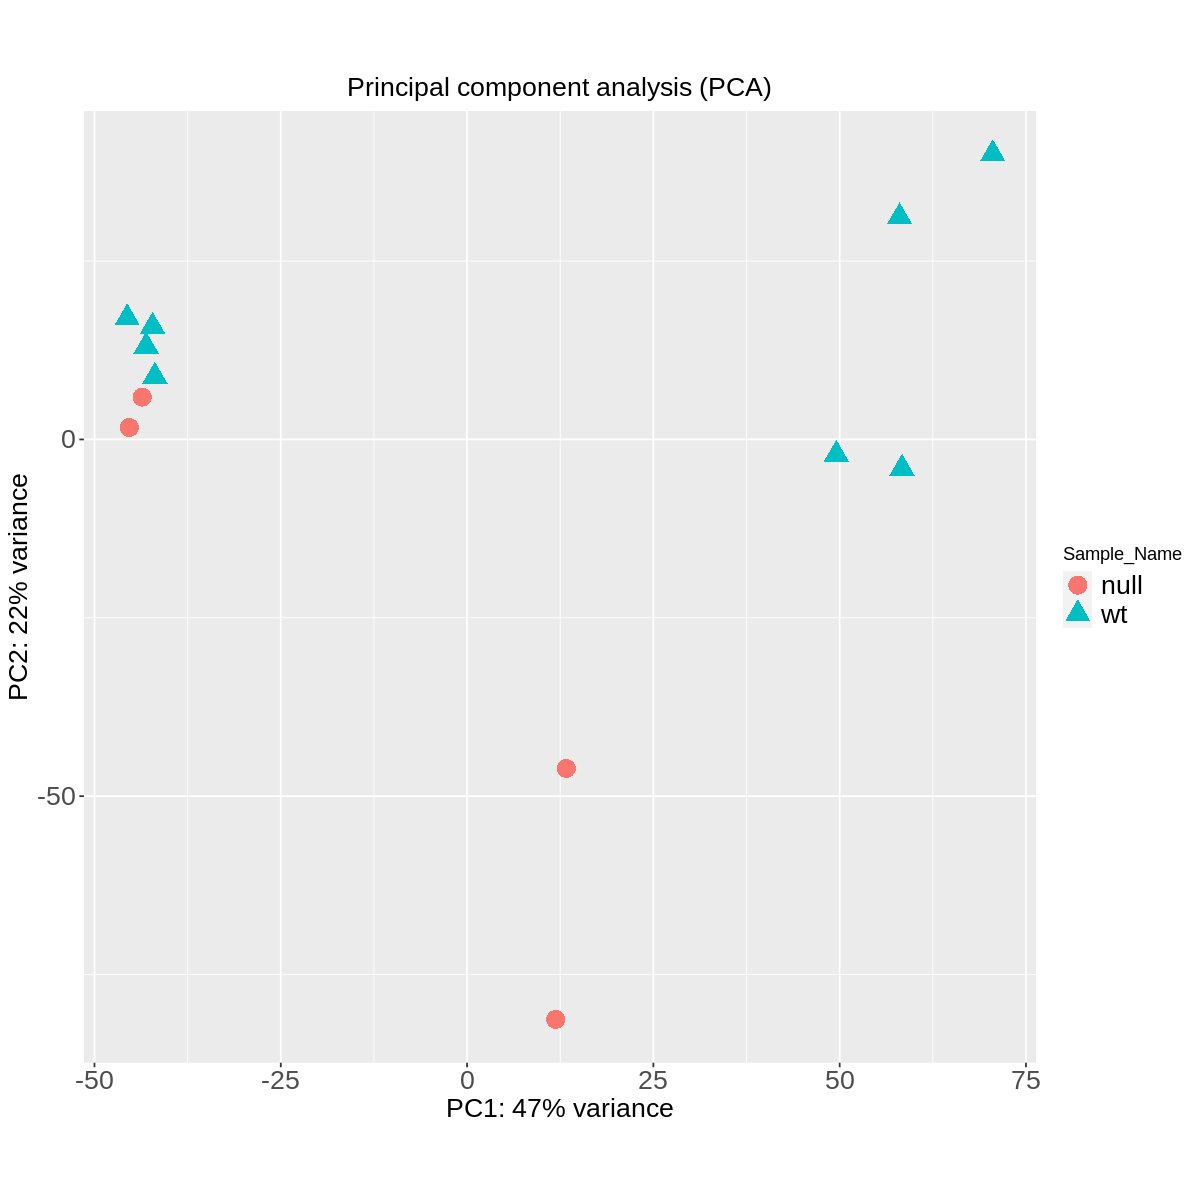

In [26]:
# This increases the plotted figure size
PCAplot()

*   Plot principal components **1** and **3** instead of **1** and **2**

In [0]:
PCAplot_1xx <- function() {   #PCA
	 x <- convertedData.out;
	 pca.object <- prcomp(t(x))
		
	pcaData = as.data.frame(pca.object$x[,1:3]); pcaData = cbind(pcaData,detectGroups_1xx(colnames(x)) )
	colnames(pcaData) = c("PC1", "PC3", "Sample_Name")
	percentVar=round(100*summary(pca.object)$importance[2,1:2],0)
	if(is.null(readSampleInfo.out)) { 
		p=ggplot(pcaData, aes(PC1, PC3, color=Sample_Name, shape = Sample_Name)) + geom_point(size=5) 
		} else {
		pcaData = cbind(pcaData,readSampleInfo.out )
		p=ggplot(pcaData, aes_string("PC1", "PC3", color=input_selectFactors,shape=input_selectFactors2)) + geom_point(size=5) 
		
		}
	p=p+xlab(paste0("PC1: ",percentVar[1],"% variance")) 
	p=p+ylab(paste0("PC3: ",percentVar[2],"% variance")) 
	p=p+ggtitle("Principal component analysis (PCA)")+coord_fixed(ratio=1.0)+ 
     theme(plot.title = element_text(size = 16,hjust = 0.5)) + theme(aspect.ratio=1) +
	 theme(axis.text.x = element_text( size = 16),
	       axis.text.y = element_text( size = 16),
		   axis.title.x = element_text( size = 16),
		   axis.title.y = element_text( size = 16) ) +
	theme(legend.text=element_text(size=16))
	   print(p)
}

ERROR: ignored

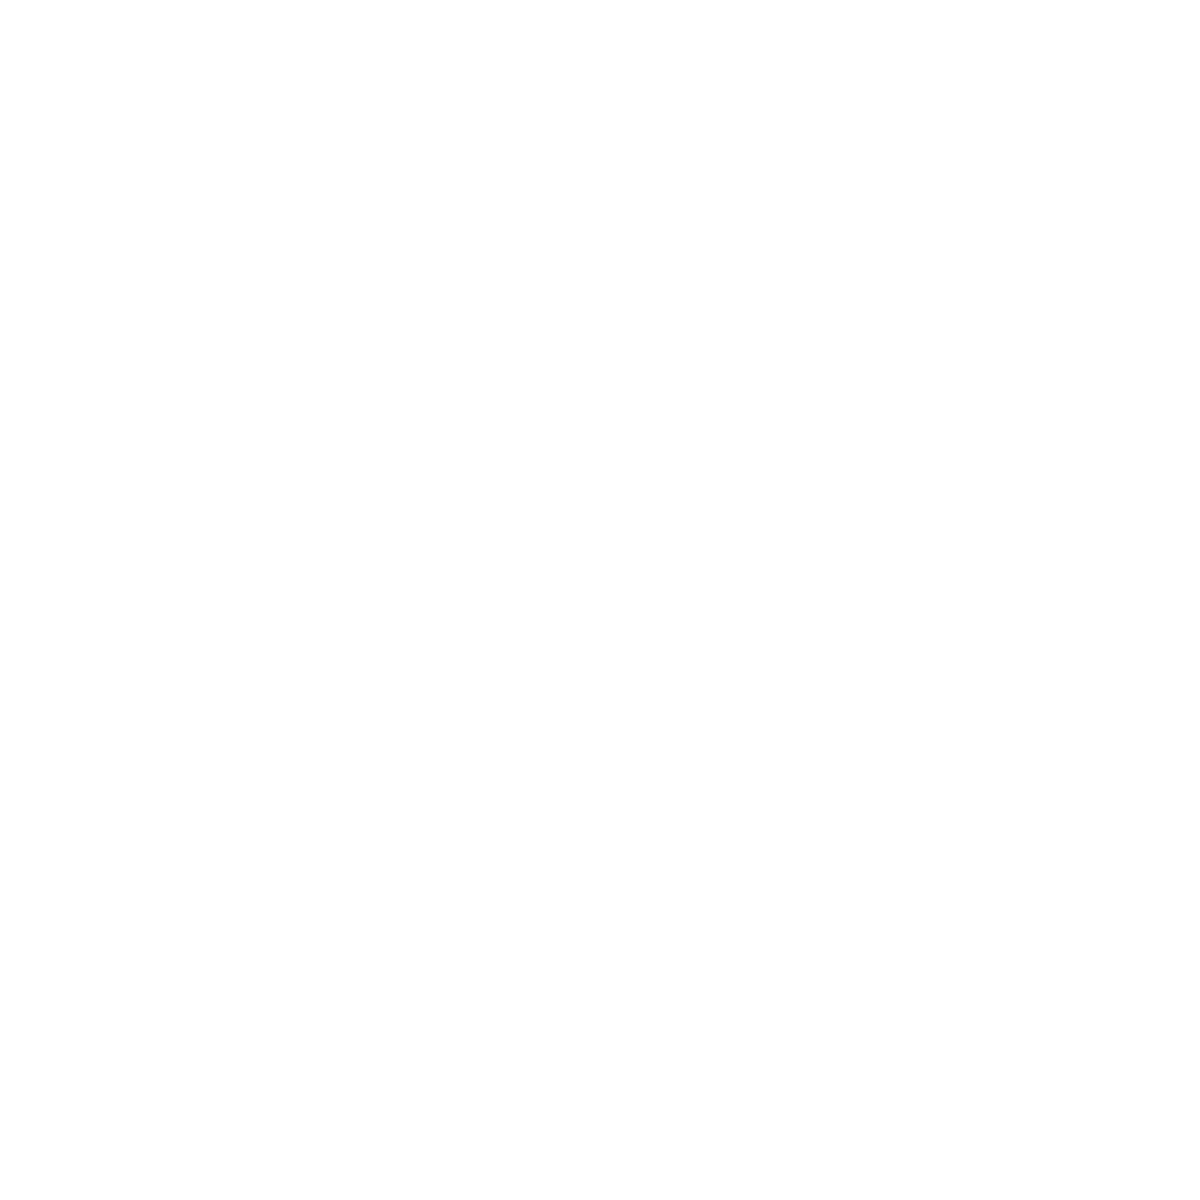

In [28]:
PCAplot_1xx()

As seen above the first obvious mistake is **1:3** in the indexing part:

`pcaData = as.data.frame(pca.object$x[,1:3]);`

Here **1:3** means columns from 1 to including 3, so we should change that to 1 and 3

In [0]:
PCAplot_2xx <- function() {   #PCA
	 x <- convertedData.out;
	 pca.object <- prcomp(t(x))
		
	pcaData = as.data.frame(pca.object$x[,c(1,3)]); pcaData = cbind(pcaData,detectGroups_1xx(colnames(x)) )
	colnames(pcaData) = c("PC1", "PC3", "Sample_Name")
	percentVar=round(100*summary(pca.object)$importance[2,1:2],0)
	if(is.null(readSampleInfo.out)) { 
		p=ggplot(pcaData, aes(PC1, PC3, color=Sample_Name, shape = Sample_Name)) + geom_point(size=5) 
		} else {
		pcaData = cbind(pcaData,readSampleInfo.out )
		p=ggplot(pcaData, aes_string("PC1", "PC3", color=input_selectFactors,shape=input_selectFactors2)) + geom_point(size=5) 
		
		}
	p=p+xlab(paste0("PC1: ",percentVar[1],"% variance")) 
	p=p+ylab(paste0("PC3: ",percentVar[2],"% variance")) 
	p=p+ggtitle("Principal component analysis (PCA)")+coord_fixed(ratio=1.0)+ 
     theme(plot.title = element_text(size = 16,hjust = 0.5)) + theme(aspect.ratio=1) +
	 theme(axis.text.x = element_text( size = 16),
	       axis.text.y = element_text( size = 16),
		   axis.title.x = element_text( size = 16),
		   axis.title.y = element_text( size = 16) ) +
	theme(legend.text=element_text(size=16))
	   print(p)
}

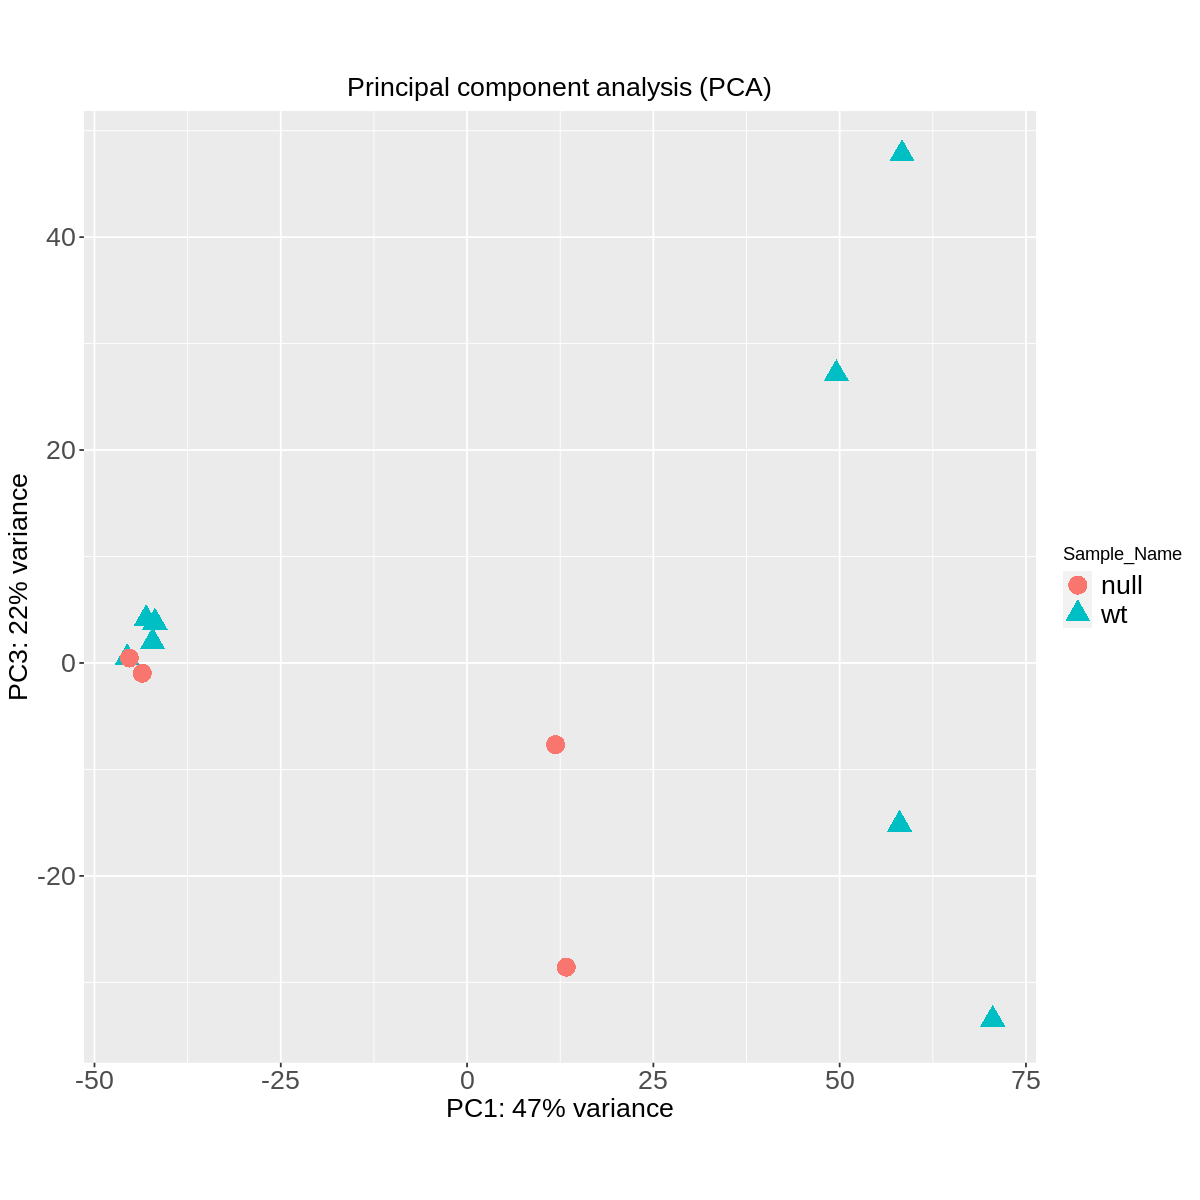

In [30]:
PCAplot_2xx()

Well, figure looks different, but explained variance in axes are similar to the previous figure. Thus, we need to try changing the following part, which might provide correct variance:

`percentVar=round(100*summary(pca.object)$importance[2,1:2],0)`

And we already now that it should be **c(1,3)**, which is a vector of two integers: 1 and 3

In [0]:
PCAplot_3xx <- function() {   #PCA
	 x <- convertedData.out;
	 pca.object <- prcomp(t(x))
		
	pcaData = as.data.frame(pca.object$x[,c(1,3)]); pcaData = cbind(pcaData,detectGroups_1xx(colnames(x)) )
	colnames(pcaData) = c("PC1", "PC3", "Sample_Name")
	percentVar=round(100*summary(pca.object)$importance[2,c(1,3)],0)
	if(is.null(readSampleInfo.out)) { 
		p=ggplot(pcaData, aes(PC1, PC3, color=Sample_Name, shape = Sample_Name)) + geom_point(size=5) 
		} else {
		pcaData = cbind(pcaData,readSampleInfo.out )
		p=ggplot(pcaData, aes_string("PC1", "PC3", color=input_selectFactors,shape=input_selectFactors2)) + geom_point(size=5) 
		
		}
	p=p+xlab(paste0("PC1: ",percentVar[1],"% variance")) 
	p=p+ylab(paste0("PC3: ",percentVar[2],"% variance")) 
	p=p+ggtitle("Principal component analysis (PCA)")+coord_fixed(ratio=1.0)+ 
     theme(plot.title = element_text(size = 16,hjust = 0.5)) + theme(aspect.ratio=1) +
	 theme(axis.text.x = element_text( size = 16),
	       axis.text.y = element_text( size = 16),
		   axis.title.x = element_text( size = 16),
		   axis.title.y = element_text( size = 16) ) +
	theme(legend.text=element_text(size=16))
	   print(p)
}

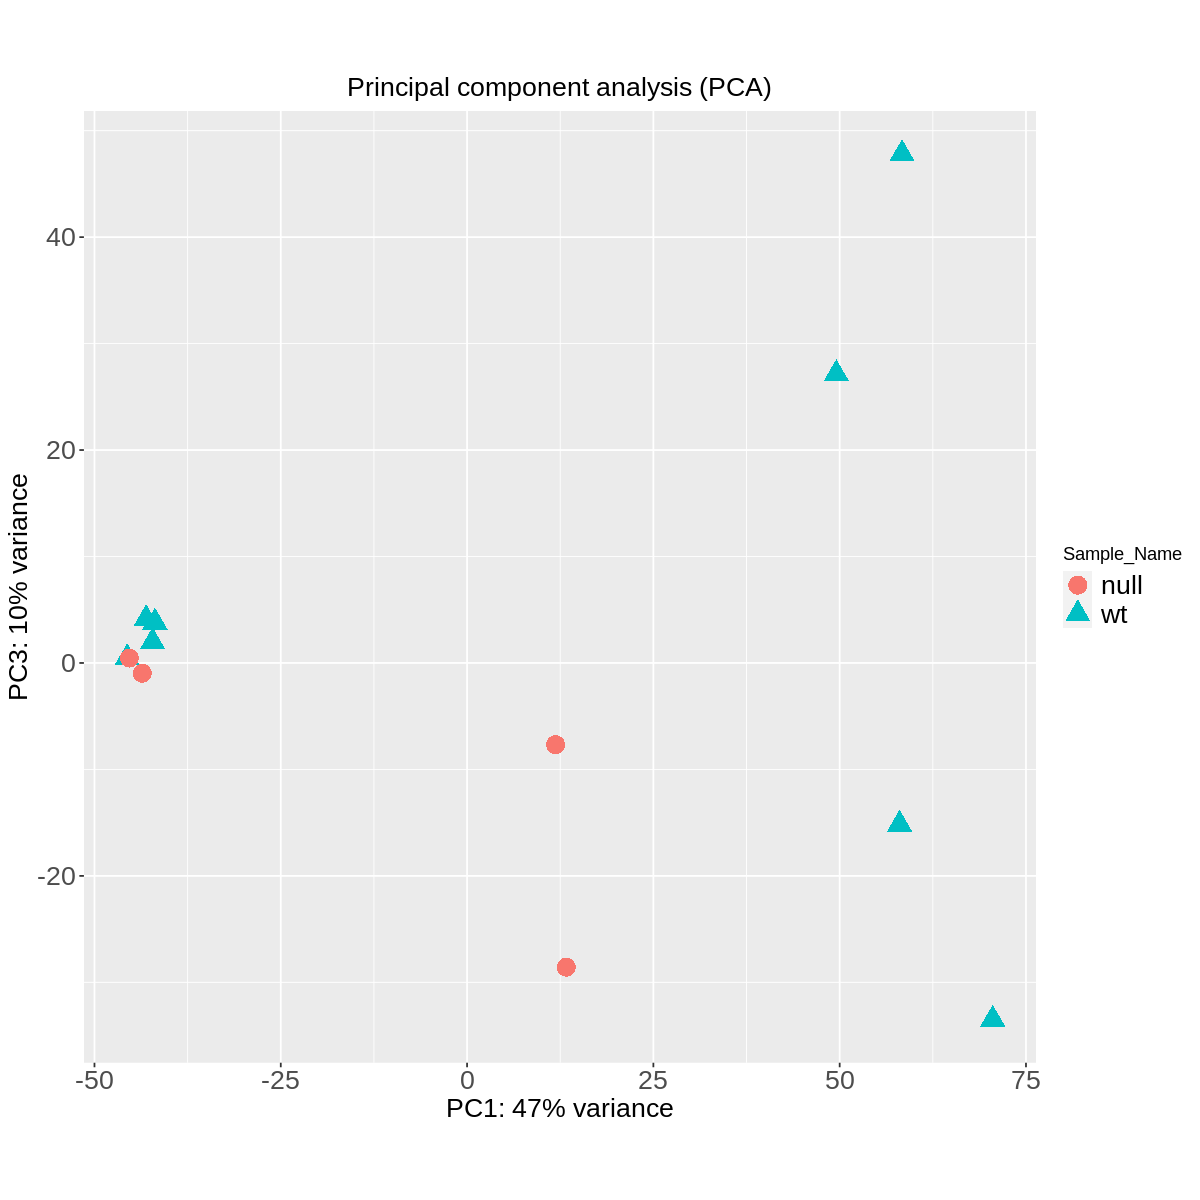

In [33]:
PCAplot_3xx()

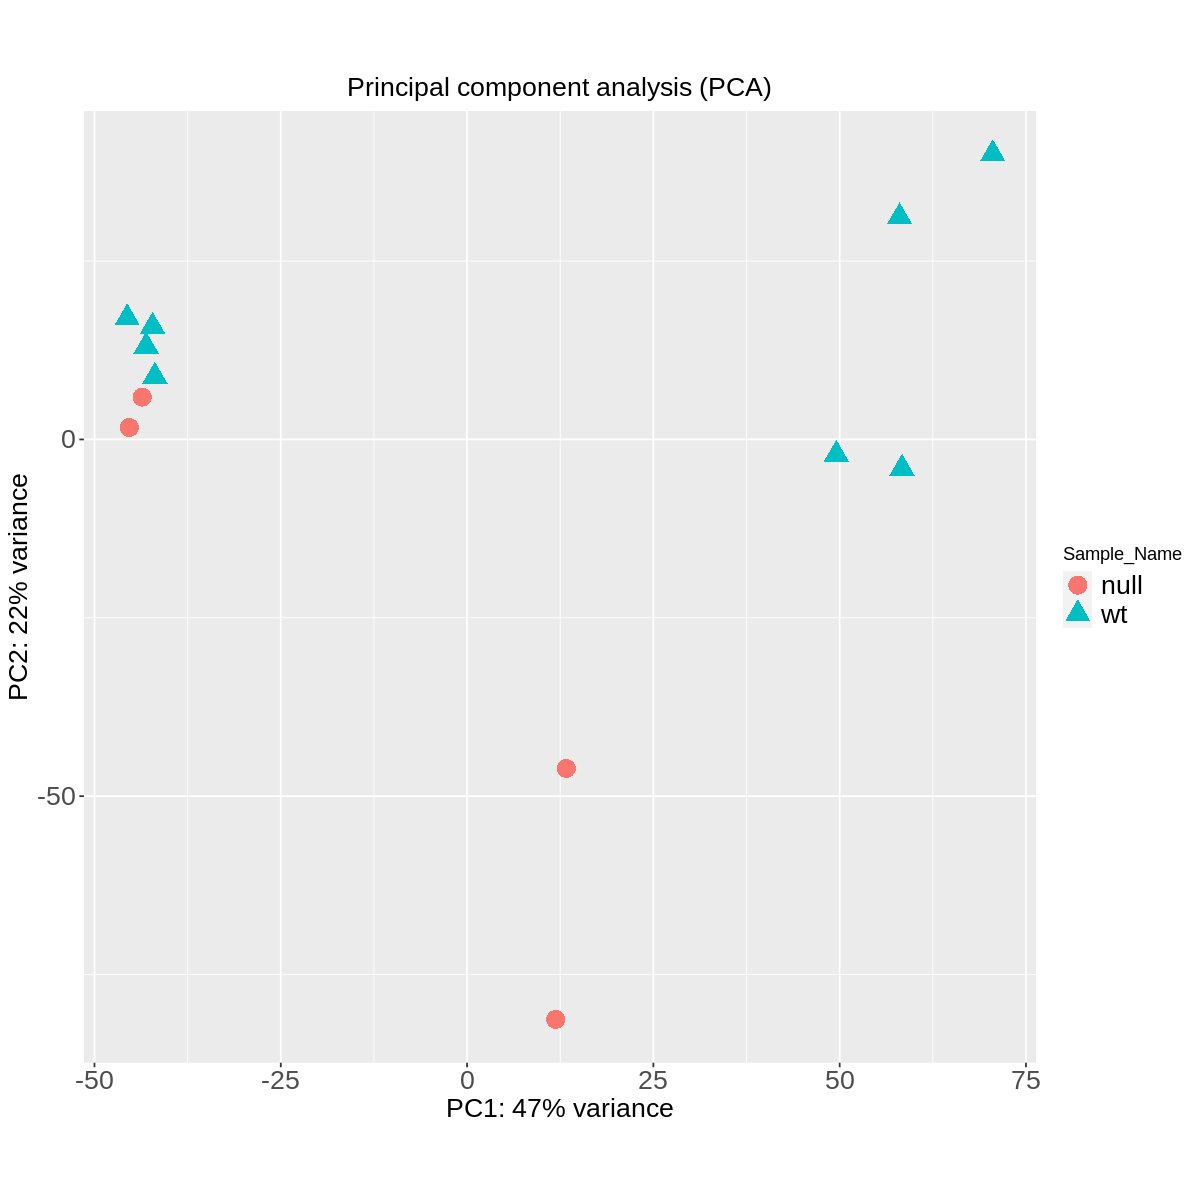

In [50]:
PCAplot()

#### Delving more into the code
We can just copy and paste every line PCAplot* functions to see what happens...

In [0]:
x <- convertedData.out;
pca.object <- prcomp(t(x))

In [55]:
pca.object$sdev

[1] 4.856884e+01 3.324578e+01 2.192494e+01 1.692593e+01 1.545167e+01
 [6] 1.244632e+01 1.105884e+01 9.897433e+00 9.401982e+00 8.008570e+00
[11] 7.193179e+00 4.196424e-14

In [37]:
summary(pca.object)

Importance of components:
                           PC1     PC2     PC3      PC4      PC5      PC6
Standard deviation     48.5688 33.2458 21.9249 16.92593 15.45167 12.44632
Proportion of Variance  0.4672  0.2189  0.0952  0.05673  0.04728  0.03068
Cumulative Proportion   0.4672  0.6860  0.7812  0.83797  0.88525  0.91593
                            PC7    PC8     PC9   PC10    PC11      PC12
Standard deviation     11.05884 9.8974 9.40198 8.0086 7.19318 4.196e-14
Proportion of Variance  0.02422 0.0194 0.01751 0.0127 0.01025 0.000e+00
Cumulative Proportion   0.94015 0.9596 0.97705 0.9898 1.00000 1.000e+00

In [39]:
percentVar=round(100*summary(pca.object)$importance[2,c(1,3)],0)
print(percentVar)

PC1 PC3 
 47  10 


#### Session information for reproducing the results
Reproducing results from other researchers doesn't only need availability of data, but also correct annotation of software. Thus, used software as well as versions of the used software need to be recorded in addition to data and code.

In [70]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] repr_1.1.0                  ggplot2_3.3.0              
 [3] e1071_1.7-3                 DESeq2_1.26.0              
 [5] SummarizedExperiment_1.16.1 DelayedArray_0.12.3        
 [7] BiocParallel_1.20.1         matrixStats_0.56.0         
 [

#### Extra steps for improvement

In [71]:
install.packages('ggfortify')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



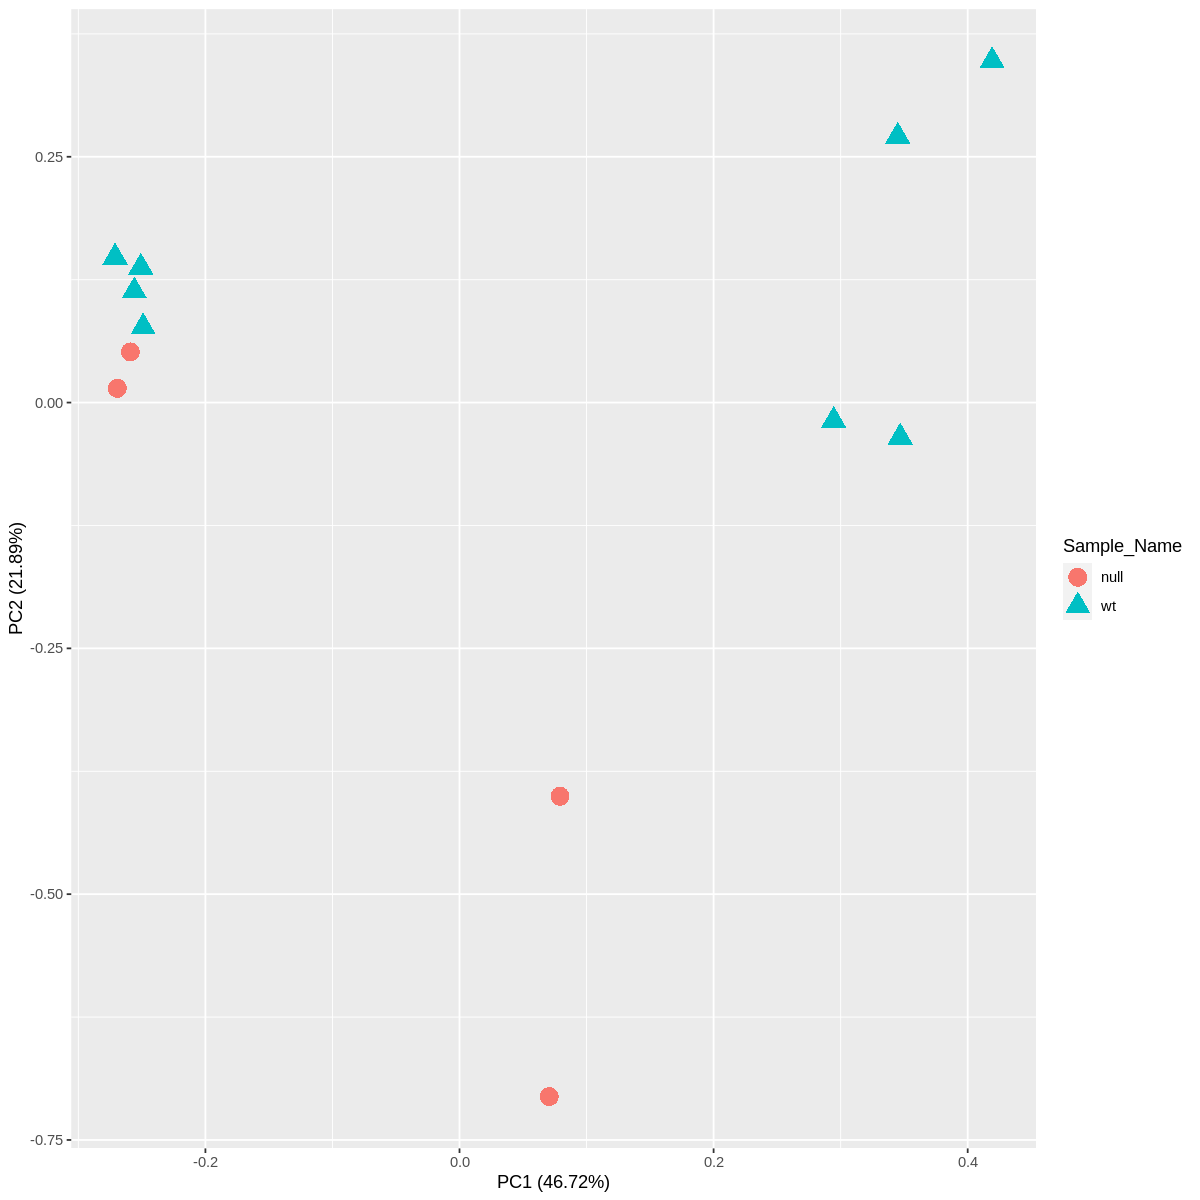

In [92]:
library("ggfortify")
pcaData = as.data.frame(pca.object$x[,1:2]); pcaData = cbind(pcaData,detectGroups_1xx(colnames(x)) )
colnames(pcaData) = c("PC1", "PC2", "Sample_Name")
autoplot(pca.object,data=pcaData, colour="Sample_Name", shape="Sample_Name",size=5) 

#### Below figure shows conribution of each gene to each sample in PCA

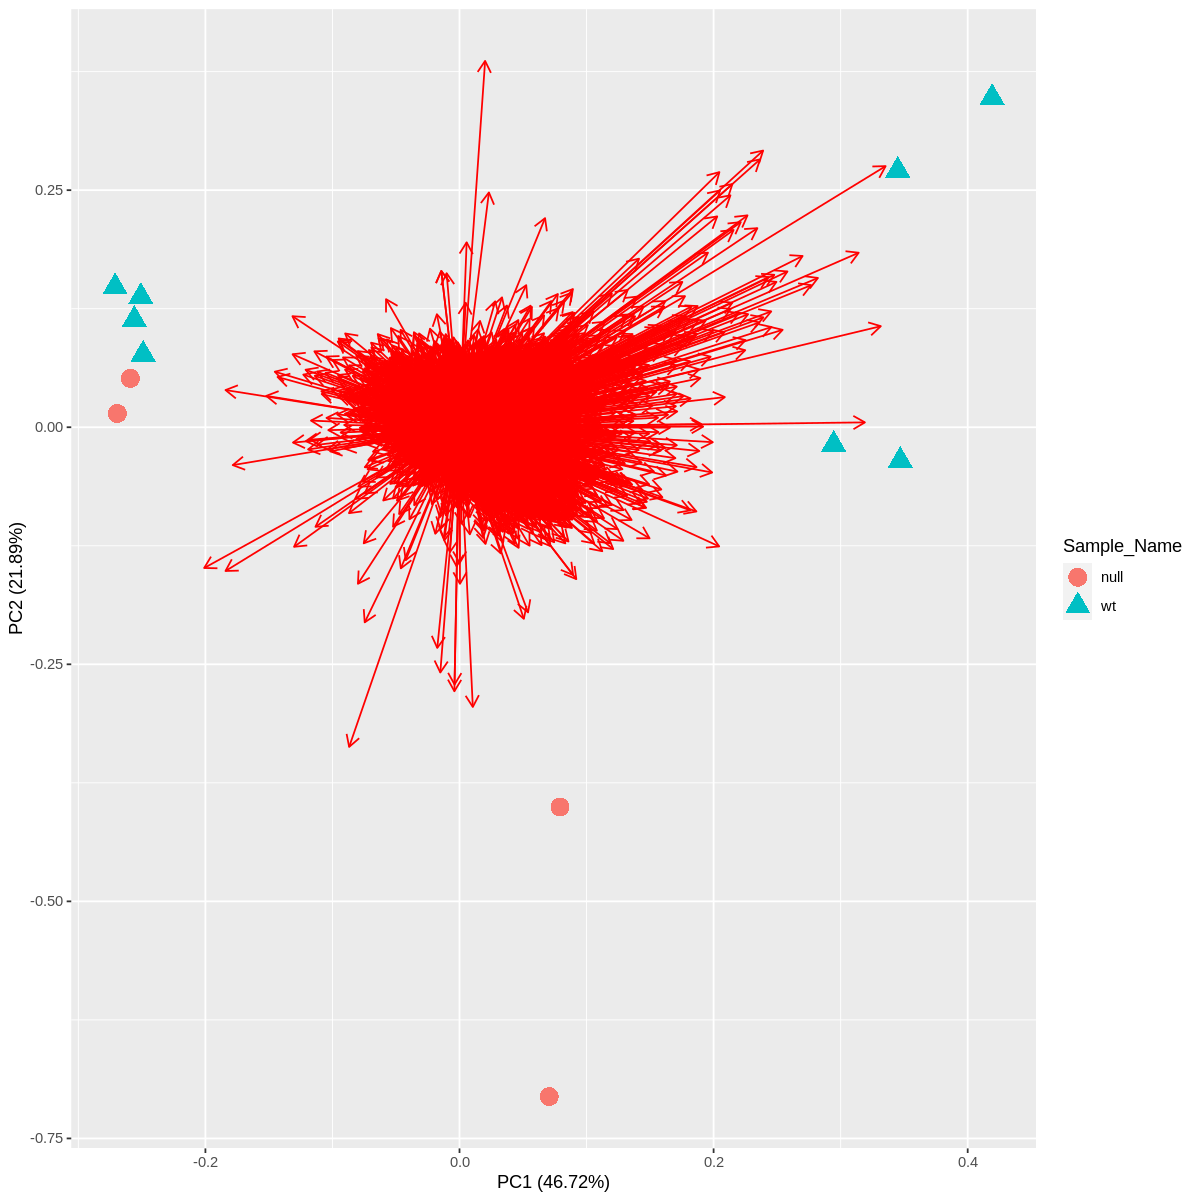

In [93]:
library("ggfortify")
pcaData = as.data.frame(pca.object$x[,1:2]); pcaData = cbind(pcaData,detectGroups_1xx(colnames(x)) )
colnames(pcaData) = c("PC1", "PC2", "Sample_Name")
autoplot(pca.object,data=pcaData, colour="Sample_Name", shape="Sample_Name",size=5, loadings=TRUE) 

In [104]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] cluster_2.1.0               ggfortify_0.4.10           
 [3] repr_1.1.0                  ggplot2_3.3.0              
 [5] e1071_1.7-3                 DESeq2_1.26.0              
 [7] SummarizedExperiment_1.16.1 DelayedArray_0.12.3        
 [